In [1]:
!pip install pandas matplotlib 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 17.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 25.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 8.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 32.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 11.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 7.

In [2]:
import numpy as np 
import pandas as pd 
# fix this
#from src.dataset.util import read_jsonl, write_jsonl
import json
import os
import matplotlib.pyplot as plt

/tmp/ipykernel_324/3886536466.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def read_jsonl(path: str) -> list[dict]:
    """
    """
    with open(path, "r") as jsonl_file:
        object = [json.loads(line.strip()) for line in jsonl_file]
    return object


def write_jsonl(object: list[dict], path: str) -> None:
    """
    """
    with open(path, "w") as jsonl_file:
        for data_dict in object:
            # Write each dictionary as a separate line in the jsonl file
            jsonl_file.write(json.dumps(data_dict) + "\n")

In [4]:
# read json file with publications
embs = read_jsonl('../data/interim/publications_parsed.ndjson')

# read in metadata from 'processed' folder
PROCESSED_PATH = '../data/processed/'
meta = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_months.csv'), sep=';')

In [6]:
# add publication ID to merge the metadata and data
embs_df = pd.DataFrame(embs).drop(columns=['pub_date'])
embs_df['pub_id'] = embs_df['id']
embs_df.head()

,title,authors,abstract,sections,references,figures,formulas,doi,path,id,pub_id
0,,,,"[{'heading': '', 'text': 'for other things and...",[],"[{'figure_label': '', 'figure_type': 'table', ...",[],,data/raw/publications_manual_export/UTA public...,p1,p1
1,Animated triangles: An eye tracking investigation,Annette M Klein; Jan Zwickel; Wolfgang Prinz; ...,"This article may be used for research, teachin...","[{'heading': '', 'text': 'In their classic wor...",[{'title': 'Do triangles play tricks? Attribut...,"[{'figure_label': '1', 'figure_type': '', 'fig...",[],10.1080/17470210802384214,data/raw/publications_manual_export/UTA public...,p2,p2
2,Implicit and Explicit Processes in Social Cogn...,Chris D Frith; Uta Frith; D M Amodio; C D Frit...,,"[{'heading': '', 'text': 'In this review we co...",[{'title': 'Meeting of minds: the medial frona...,[],[],10.1016/j.neuron.2008.10.032,data/raw/publications_manual_export/UTA public...,p3,p3
3,Do readers with autism make bridging inference...,David Saldaña; Uta Frith; S Baron-Cohen; H Tag...,Individuals with autism frequently show impair...,"[{'heading': 'Introduction', 'text': 'In a sim...",[{'title': 'Understanding other minds: Perspec...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],10.1016/j.jecp.2006.11.002,data/raw/publications_manual_export/UTA public...,p4,p4
4,Implicit and Explicit Processes in Social Cogn...,Chris D Frith; Uta Frith; D M Amodio; C D Frit...,,"[{'heading': '', 'text': 'In this review we co...",[{'title': 'Meeting of minds: the medial frona...,[],[],10.1016/j.neuron.2008.10.032,data/raw/publications_manual_export/UTA public...,p5,p5


In [7]:
# add publication date column
dates = []
for i, row in meta.iterrows():
    year_month = f"{int(row['year'])}-{int(row['month'])}-01"
    pub_date = pd.to_datetime(year_month, format='%Y-%m-%d')
    dates.append(pub_date)

meta['date'] = dates
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   pub_id  272 non-null    object        
 1   path    272 non-null    object        
 2   doi     142 non-null    object        
 3   source  272 non-null    object        
 4   year    272 non-null    float64       
 5   month   272 non-null    int64         
 6   date    272 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 15.0+ KB


In [8]:
# only include publications with quality data
quality = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_quality.csv'))
# clean up quality
rows_to_include = []
for i, group in quality.groupby('pub_id'):
    # pick the pub_id with high n_characters
    top_row_in_grp = group['n_characters'].idxmax()
    rows_to_include.append(top_row_in_grp)

quality_short = quality.loc[rows_to_include]
quality_short.drop(columns=['Unnamed: 0', 'year', 'date', 'title', 'source'], inplace=True)
quality_short.reset_index(drop=True, inplace=True)

In [9]:
# merge embeddings with metadata
df = embs_df.merge(meta[['pub_id', 'year', 'source', 'date']], on='pub_id', how='left')
df = df.merge(quality_short, on='pub_id', how='left')
# sort by date!
df = df.sort_values('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271 entries, 188 to 64
Data columns (total 91 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   title                                   271 non-null    object        
 1   authors                                 271 non-null    object        
 2   abstract                                271 non-null    object        
 3   sections                                271 non-null    object        
 4   references                              271 non-null    object        
 5   figures                                 271 non-null    object        
 6   formulas                                271 non-null    object        
 7   doi_x                                   271 non-null    object        
 8   path_x                                  271 non-null    object        
 9   id                                      271 non-null    ob

In [10]:
# only include relevant columns, first 13 columns
df_subset = df.iloc[:, 0:13]
df_subset.head()

The 'sections' column in the dataframe contains a list all the sections in the paper (as dicts). 

In [29]:
# look at the second section in the second paper
df_subset['sections'][1][1]

{'heading': 'Method',
 'text': 'Participants A total of 31 participants (21 females and 10 males) ranging in age from 20 to 29 years (mean 23) participated. All had normal or correctedto-normal vision.',
 'n_publication_ref': 0,
 'n_figure_ref': 0}

Above is an example of dict with the paper section, containing the heading and text. We want to go through each of the section headings and look for the word 'method', in order to count the number of papers that contain section headings.

In [13]:
# word to look for
word = 'method'

# initialize empty list
methods_binary = []

# go over each row (=paper) in the dataframe
for i in range(len(df_subset)):

    section = df_subset['sections'][i]

    headings_list = []

    # go through each section of that paper
    for i in range(len(section)):
        # save heading name and convert to lowercase
        headings = section[i]['heading'].lower()
        # append heading name to list of headings for that paper
        headings_list.append(headings)

    #matching = [s for s in headings_list if word in s]
    #print(len(matching))
    #print(matching)

    # if any version of 'method' is in the heading (i.e., also 'methods' and 'methodlogy', for example)
    if any(word in s for s in headings_list):
        methods_binary.append('yes')

    else:
        methods_binary.append('no')

In [14]:
# add list as column
df_subset['methods_section'] = methods_binary

In [15]:
# convert years to integers instead of floats
df_subset['year'] = df_subset['year'].astype(int)

In [16]:
df_subset.head()

,title,authors,abstract,sections,references,figures,formulas,doi_x,path_x,id,pub_id,year,source,methods_section
188,,R Brown; C Fraser; C N I N Cofer; B S Musgrave...,An experiment was designed to investigate the ...,"[{'heading': 'INTRODUCTION', 'text': 'One of t...","[{'title': 'The acquisition of syntax', 'journ...","[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p189,p189,1969,parsing,no
189,,,,"[{'heading': ' ', 'text': '(1965, 1966) have...",[],"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p190,p190,1969,parsing,yes
186,STUDIES IN PATTERN DETECTION IN NORMAL AND AUT...,Uta Frith; U Aurnhammer-Fhith; L Bartak; W R G...,"Normal, autistic, and subnormal children repro...","[{'heading': '', 'text': 'It has recently been...",[{'title': 'Emphasis and meaning in recall in ...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p187,p187,1970,parsing,no
185,n t a F i t h,S E Q U E N C E S I N C H I L D R E N; F Bartl...,Younger children with a short memory span and ...,"[{'heading': '', 'text': 'I t could be hypothe...",[{'title': 'Remembering. A study i n experimen...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p186,p186,1970,parsing,yes
187,,,,"[{'heading': '', 'text': 'The hypothesis of a ...",[],"[{'figure_label': '1', 'figure_type': 'table',...",[],,data/raw/publications_manual_export/UTA public...,p188,p188,1970,parsing,no


In [22]:
# pivot df to count number of papers with and without methods sections for each year
methods_per_year = df_subset.pivot_table(index='year', columns='methods_section', aggfunc='size', fill_value=0)

# count total number of publications per year
grouped = df_subset.groupby('year').size()
methods_per_year['publications'] = grouped

# calculate the ratio of papers with methods sections compared to total number of papers per year
methods_per_year['methods_ratio'] = methods_per_year['yes'] / methods_per_year['publications']
methods_per_year.head()

methods_section,no,yes,publications,methods_ratio
year,,,,
1969,1,1,2,0.500000
1970,2,1,3,0.333333
1971,2,1,3,0.333333
1972,2,1,3,0.333333
1973,4,0,4,0.000000


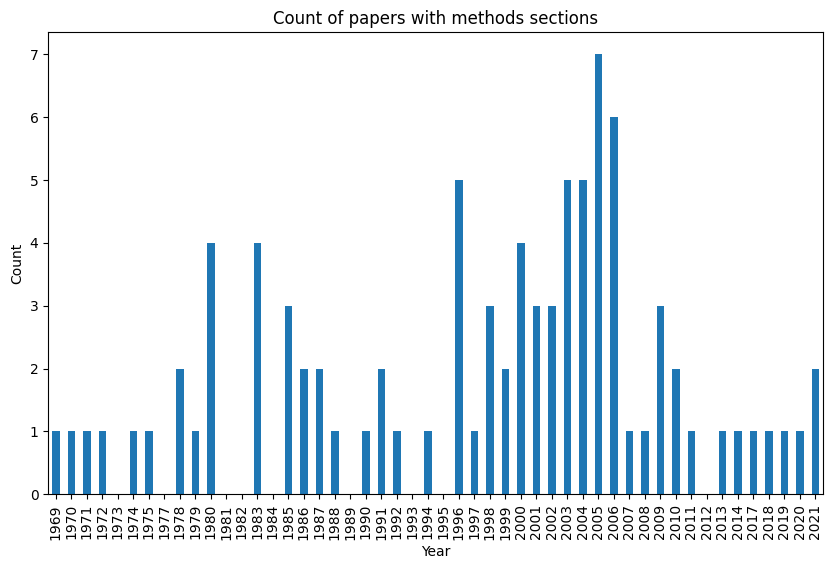

In [23]:
# plot raw count of papers with methods sections
methods_per_year['yes'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of papers with methods sections')
plt.show()

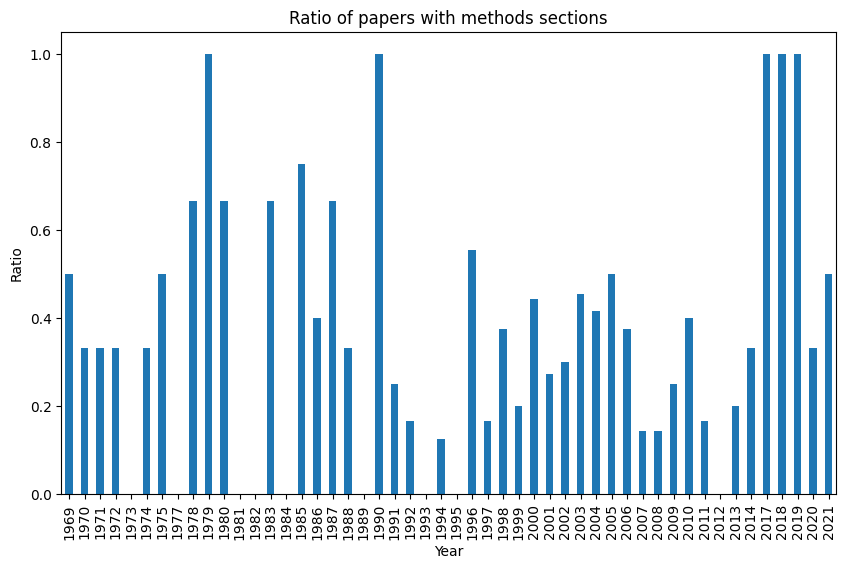

In [25]:
# plot ratio of papers with methods sections
methods_per_year['methods_ratio'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Ratio of papers with methods sections')
plt.show()